In [22]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, BatchNormalization, GlobalAveragePooling1D
from keras.optimizers import Adam, Adadelta

# from fbprophet import Prophet
# from fbprophet.diagnostics import cross_validation, performance_metrics
# silence prophet INFO messages
# import logging
# logging.getLogger('fbprophet').setLevel(logging.WARNING)

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

env: PYTHONHASHSEED=0


# Keras Neural Networks for Weather Time Series Nowcasts

Building neural networks with [keras](https://keras.io/) for time series analysis of Cambridge UK weather data.


## Import Data

Data has been cleaned but may still have issues.  See the 
[cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning)
in the 
[Cambridge Temperature Model](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
repository for details.

The `y` variable is temperature * 10.  I'm primarily interested in very short term forecasts (less than 2 hours) but forecasts over 24 hours are also interesting.

In [2]:
df = pd.read_csv("../data/CamUKWeather.csv", parse_dates = True)
print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
df

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ds                 192885 non-null  object
 1   year               192885 non-null  int64 
 2   doy                192885 non-null  int64 
 3   time               192885 non-null  object
 4   y                  192885 non-null  int64 
 5   humidity           192885 non-null  int64 
 6   dew.point          192885 non-null  int64 
 7   pressure           192885 non-null  int64 
 8   wind.speed.mean    192885 non-null  int64 
 9   wind.bearing.mean  192885 non-null  int64 
 10  wind.speed.max     192885 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80


---

## Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:
 * Wind direction and speed transformation
 * Time conversion
 * Split data
 * Normalise data
 * Window data

### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is categorised at 45 degree increments, 
i.e. 0, 45, 90, 135, 180, 225, 270, 315.  Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

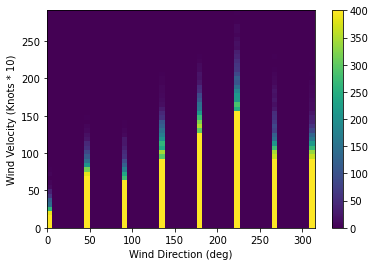

In [3]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (Knots * 10)');

Convert wind direction and speed to _x_ and _y_ vectors, so the model can more easily interpret them.

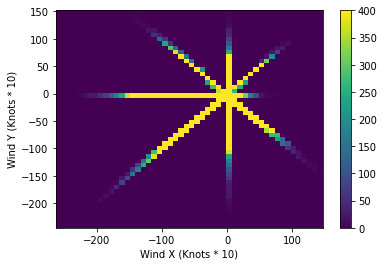

In [4]:
wv = df['wind.speed.mean']
max_wv = df['wind.speed.max']

# Convert to radians.
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components.
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max.wind.x'] = max_wv * np.cos(wd_rad)
df['max.wind.y'] = max_wv * np.sin(wd_rad)

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)');

Better, but not ideal.  Some data augmentation/regularisation with a method like 
[mixup](https://arxiv.org/abs/1710.09412) may be beneficial.


### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

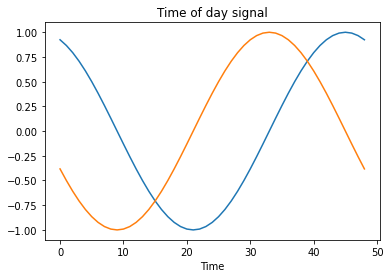

In [5]:
# convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.title('Time of day signal');

# plt.plot(np.array(df['year.sin'])[:17532])
# plt.plot(np.array(df['year.cos'])[:17532])
# plt.xlabel('Time')
# plt.title('Time of year signal');

### Split data

Use a (70%, 20%, 10%) split for the training, validation, and test sets.

In [6]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure',
             'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y', 
             'day.sin', 'day.cos', 'year.sin', 'year.cos']
del_cols = ['ds', 'year', 'doy', 'time', 
            'wind.bearing.mean', 'wind.speed.mean', 'wind.speed.max']
df_orig  = df
df.drop(del_cols, axis = 1, inplace = True)

n = len(df)
train_df = df[0:int(n * 0.7)]
valid_df = df[int(n * 0.7):int(n * 0.9)]
test_df  = df[int(n * 0.9):]

print("train shape: ", train_df.shape)
print("valid shape: ", valid_df.shape)
print("test shape:  ",  test_df.shape)

train shape:  (135019, 12)
valid shape:  (38577, 12)
test shape:   (19289, 12)


### Normalise data

Features should be scaled before neural network training.  Arguably, scaling should be done using moving averages to avoid accessing future values.  
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) 
normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) 
to see distribution of features.

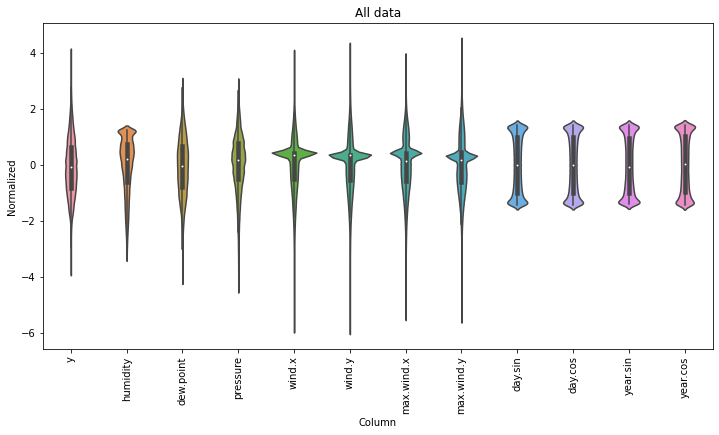

In [7]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 90)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.


### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing)
function:
 * sequence_length: Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride: Period between successive output sequences.  For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc.  s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size: Number of samples in each batch
 * shuffle: Shuffle output samples, or use chronological order
 
Initial values used:
 * sequence_length (aka lags): 4
 * steps ahead (what to forecast): 1 and separately 4
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: False
 
lags, batch_size and shuffle may be optimised later.

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead.  Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

First, check results are as expected for single batch with `shuffle = False`.
Then, process all training data with `shuffle = True`.

In [8]:
def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    data_np = np.array(data, dtype = np.float32)    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
           data    = data_np,
           targets = None,
           sequence_length = total_window_size,
           sequence_stride = 1,
           shuffle    = shuffle,
           batch_size = bs)
            
    col_indices = {name: i for i, name in enumerate(data.columns)}    
    X_slice = slice(0, lags)
    y_start = total_window_size - steps_ahead
    y_slice = slice(y_start, None)

    
    def split_window(features):   
        X = features[:, X_slice, :]
        y = features[:, y_slice, :]
        X = tf.stack(
            [X[:, :, col_indices[name]] for name in data.columns if name not in y_cols],
            axis = -1)    
        y = tf.stack(
            [y[:, :, col_indices[name]] for name in y_cols],
            axis = -1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually.  This way the `tf.data.Datasets` are easier to inspect.
        X.set_shape([None, lags,        None])
        y.set_shape([None, steps_ahead, None])

        return X, y

    
    ds = ds.map(split_window)
        
    return ds


def make_datasets(train, valid, test, 
                  y_cols = 'y', lags = 1, steps_ahead = 1, 
                  stride = 1, bs = 32, shuffle = False):
    ds_train = make_dataset(train, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_valid = make_dataset(valid, y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    ds_test  = make_dataset(test,  y_cols, 
                             lags = lags, steps_ahead = steps_ahead, stride = stride, shuffle = shuffle)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):
    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0]) 
    
    return 1


# Single step-ahead
lags = 4
ds_train_4l_1s, ds_valid_4l_1s, ds_test_4l_1s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = lags)
dataset_sanity_checks(ds_train_4l_1s, '1s train');

# 4 steps-ahead
steps = stride = 4
ds_train_4l_4s, ds_valid_4l_4s, ds_test_4l_4s = make_datasets(train_df, valid_df, test_df, 
                                                              lags = lags, steps_ahead = steps, stride = stride)
display(train_df.head(lags + steps))
dataset_sanity_checks(ds_train_4l_4s, '4s train');

1s train batches:  4220
	X (batch_size, time, features):  (32, 4, 11)
	y (batch_size, time, features):  (32, 1, 1)
	X[0][0]:  tf.Tensor(
[[-0.61904097  1.2185533  -0.3453114  -2.4908588   0.34234142 -2.4654448
   0.31408057  1.3076388  -0.5406091  -0.68975085 -1.2293116 ]
 [-0.55924916  1.3554462  -0.3453114  -2.823824    0.34234142 -2.2577734
   0.31408057  1.2258644  -0.7066079  -0.6901866  -1.229056  ]
 [-0.6788328   1.33589    -0.3453114  -2.728691    0.34234142 -2.2577734
   0.31408057  1.1231456  -0.8605014  -0.6906223  -1.2288003 ]
 [-0.6788328   1.4336708  -0.3453114  -2.6335583   0.34234142 -2.0501022
   0.31408057  1.0012399  -0.99965656 -0.6910579  -1.2285445 ]], shape=(4, 11), dtype=float32)
	y[0][0]:  tf.Tensor([[1.6880062]], shape=(1, 1), dtype=float32)


,y,humidity,dew.point,pressure,wind.x,wind.y,max.wind.x,max.wind.y,day.sin,day.cos,year.sin,year.cos
0,1.268343,-0.619041,1.218553,-0.345311,-2.490859,0.342341,-2.465445,0.314081,1.307639,-0.540609,-0.689751,-1.229312
1,1.346058,-0.559249,1.355446,-0.345311,-2.823824,0.342341,-2.257773,0.314081,1.225864,-0.706608,-0.690187,-1.229056
2,1.408231,-0.678833,1.335890,-0.345311,-2.728691,0.342341,-2.257773,0.314081,1.123146,-0.860501,-0.690622,-1.228800
3,1.485946,-0.678833,1.433671,-0.345311,-2.633558,0.342341,-2.050102,0.314081,1.001240,-0.999657,-0.691058,-1.228544
4,1.688006,-1.097376,1.355446,-0.345311,-3.014090,0.342341,-2.257773,0.314081,0.862233,-1.121692,-0.691493,-1.228288
5,1.688006,-1.216959,1.257666,-0.259427,-2.942740,0.342341,-2.465445,0.314081,0.708503,-1.224521,-0.691929,-1.228032
6,1.625834,-1.216959,1.179441,-0.345311,-1.835855,-2.081727,-1.613888,-1.803204,0.542682,-1.306382,-0.692364,-1.227776
7,1.750178,-1.097376,1.414115,-0.345311,-2.086544,0.342341,-1.634760,0.314081,0.367605,-1.365876,-0.692799,-1.227519


4s train batches:  4220
	X (batch_size, time, features):  (32, 4, 11)
	y (batch_size, time, features):  (32, 4, 1)
	X[0][0]:  tf.Tensor(
[[-0.61904097  1.2185533  -0.3453114  -2.4908588   0.34234142 -2.4654448
   0.31408057  1.3076388  -0.5406091  -0.68975085 -1.2293116 ]
 [-0.55924916  1.3554462  -0.3453114  -2.823824    0.34234142 -2.2577734
   0.31408057  1.2258644  -0.7066079  -0.6901866  -1.229056  ]
 [-0.6788328   1.33589    -0.3453114  -2.728691    0.34234142 -2.2577734
   0.31408057  1.1231456  -0.8605014  -0.6906223  -1.2288003 ]
 [-0.6788328   1.4336708  -0.3453114  -2.6335583   0.34234142 -2.0501022
   0.31408057  1.0012399  -0.99965656 -0.6910579  -1.2285445 ]], shape=(4, 11), dtype=float32)
	y[0][0]:  tf.Tensor(
[[1.6880062]
 [1.6880062]
 [1.6258337]
 [1.7501785]], shape=(4, 1), dtype=float32)


---


## Model Building

First, I compare unoptimised model architectures.  Then I optimise the best performing architecture.

Model architectures considered:
 * MLP
 * [FCN](https://arxiv.org/abs/1611.06455)
 * ResNet

I'm primarily interested in "now-casting" or forecasting in the next 1 or 2 hours.
The following model outputs are investigated:
 * Single step ahead - 30 mins
 * Multi-step ahead - 30, 60, 90 and 120 mins

The training and validation code are stored in the `compile_fit_validate` function.


### Multi-layer perceptron


run_model - optimizer: adadelta
Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_44 (Dropout)         (None, 4, 11)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 4, 500)            6000      
_________________________________________________________________
dropout_45 (Dropout)         (None, 4, 500)            0         
_________________________________________________________________
dense_48 (Dense)             (None, 4, 500)            250500    
_________________________________________________________________
dropout_46 (Dropout)         (None, 4, 500)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 4, 500)            250500    
_________________________________________________________________
dropout_47 (Dropout)         (N

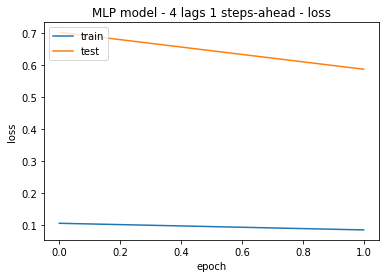

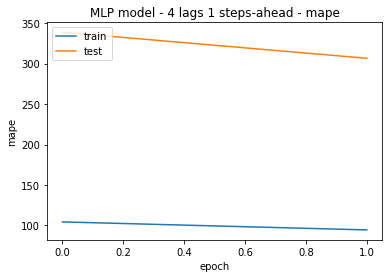

MLP model - 4 lags 1 steps-ahead - train min loss: 0.085787	mae: 0.213187	mape: 94.373825	epoch: 2
MLP model - 4 lags 1 steps-ahead - valid min loss: 0.586596	mae: 0.659181	mape: 306.654022	epoch: 2



In [31]:
def compile_fit_validate(model, train, valid, optimizer, epochs = 5, verbose = 1):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if optimizer.lower() == 'adadelta':
        opt = Adadelta(lr = 1.0)
    else:
        opt = Adam(lr = 0.001)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape'])    
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose)
    
    return h

    
def plot_history(h, name):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    plt.plot(h.history['mape'])
    plt.plot(h.history['val_mape'])
    plt.title(name + ' mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show();

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


# For testing compile_fit_validate, plot_progress etc
def build_small_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    small = Sequential(name = name)
    
    small.add(Input(shape = in_shape))
    
    small.add(Dense(64, activation = 'relu'))
    small.add(Dense(64, activation = 'relu'))
    
    small.add(Dense(1))
    
    return small


def build_mlp_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Dropout(0.1))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.2))
    
    mlp.add(Dense(500, activation = 'relu'))
    mlp.add(Dropout(0.3))
    
    mlp.add(Dense(1))
    
    return mlp


def run_model(model, train, valid, optimizer = 'adam', epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, optimizer, epochs)
    plot_history(h, model_id)
    print_min_loss(h, model_id)
    
    return h
    

# For testing purposes
# name = 'small'
# small_4l_1s = build_small_model(name, ds_train_4l_1s)
# run_model(small_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 2)
# small_4l_4s = build_small_model(name, ds_train_4l_4s)
# run_model(small_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 2)


name = 'MLP'
mlp_4l_1s   = build_mlp_model(name, ds_train_4l_1s)
h_mlp_4l_1s = run_model(mlp_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, optimizer = 'adadelta', epochs = 2)

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_20 (Dropout)         (None, 4, 11)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 4, 500)            6000      
_________________________________________________________________
dropout_21 (Dropout)         (None, 4, 500)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 4, 500)            250500    
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 500)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 4, 500)            250500    
_________________________________________________________________
dropout_23 (Dropout)         (None, 4, 500)            0       

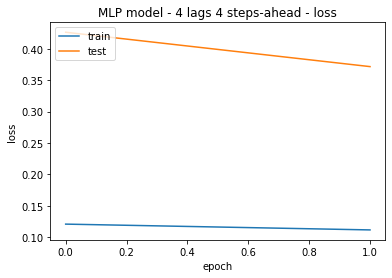

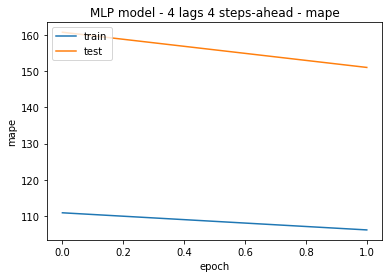

MLP model - 4 lags 4 steps-ahead - train min loss: 0.111840	mae: 0.246514	mape: 106.143440	epoch: 2
MLP model - 4 lags 4 steps-ahead - valid min loss: 0.371614	mae: 0.486880	mape: 151.056580	epoch: 2



In [24]:
mlp_4l_4s   = build_mlp_model(name, ds_train_4l_4s)
h_mlp_4l_4s = run_model(mlp_4l_1s, ds_train_4l_4s, ds_valid_4l_4s, optimizer = 'adadelta', epochs = 2)

### Fully convolutional network

...

See [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455)
for a detailed description of the Fully Convolutional Network (FCN) architecture.

...

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 4, 128)            11392     
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 128)            512       
_________________________________________________________________
activation_6 (Activation)    (None, 4, 128)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 4, 256)            164096    
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 256)            1024      
_________________________________________________________________
activation_7 (Activation)    (None, 4, 256)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4, 128)            98432   

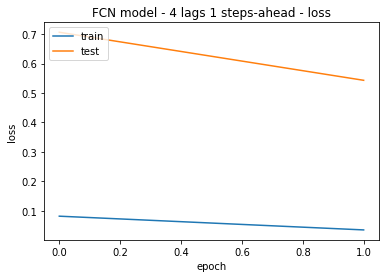

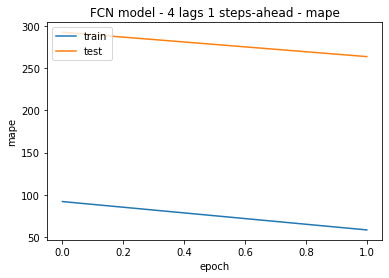

FCN model - 4 lags 1 steps-ahead - train min loss: 0.035045	mae: 0.134325	mape: 58.492069	epoch: 2
FCN model - 4 lags 1 steps-ahead - valid min loss: 0.543025	mae: 0.585095	mape: 263.425415	epoch: 2



In [25]:
def build_fcn_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = 128, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = 128, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(1))

    return fcn


name = 'FCN'
fcn_4l_1s   = build_fcn_model(name, ds_train_4l_1s)
h_fcn_4l_1s = run_model(fcn_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 2)

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 128)            11392     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 128)            512       
_________________________________________________________________
activation_3 (Activation)    (None, 4, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 256)            164096    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 256)            1024      
_________________________________________________________________
activation_4 (Activation)    (None, 4, 256)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 128)            98432   

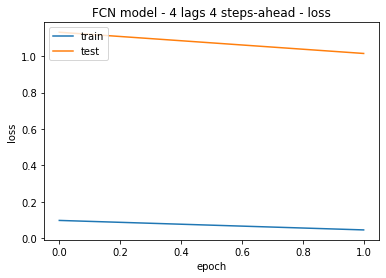

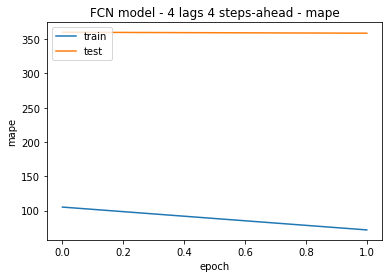

FCN model - 4 lags 4 steps-ahead - train min loss: 0.046187	mae: 0.157878	mape: 71.902214	epoch: 2
FCN model - 4 lags 4 steps-ahead - valid min loss: 1.014941	mae: 0.822382	mape: 358.648743	epoch: 2



In [12]:
fcn_4l_4s   = build_fcn_model(name, ds_train_4l_4s)
h_fcn_4l_4s = run_model(fcn_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 2)

### Residual network

...

Residual networks, or ResNets, were originally proposed in
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

...

In [ ]:
        n_feature_maps = 64
    
        # BLOCK 1

        conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.BatchNormalization()(output_block_2)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        # FINAL

        gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)


def build_resnet_model(name, data):
    in_shape, _ = get_io_shapes(data)
    
    resnet = Sequential(name = name)
    resnet.add(Input(shape = in_shape))
    
    resnet.add(Dense(1))
    
    return resnet
    

name = 'ResNet'
resnet_4l_1s   = build_resnet_model(name, ds_train_4l_1s)
h_resnet_4l_1s = run_model(resnet_4l_1s, ds_train_4l_1s, ds_valid_4l_1s, epochs = 2)

In [ ]:
resnet_4l_4s   = build_fcn_model(name, ds_train_4l_4s)
h_resnet_4l_4s = run_model(resnet_4l_4s, ds_train_4l_4s, ds_valid_4l_4s, epochs = 2)

### Architecture comparison and/or optimisation

...

Using `ds_test_1s` and `ds_test_4s`.

Plot residuals of each model.

Plot some forecasts?

Optimisation with [keras-tuner](https://github.com/keras-team/keras-tuner)?

...

---


## Conclusion

...

Compare with baselines and/or prophet results?

Future work
 * data augmentation/regularisation with a method like [mixup](https://arxiv.org/abs/1710.09412) may be beneficial for the quantised $x$ and $y$ wind vectors
   * mixup may need to be applied between consecutive observations for time series 
 * ...

...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [14]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/local/opt/python@3.8/bin/python3.8
3.8.6 (default, Oct  8 2020, 14:17:19) 
[Clang 10.0.0 (clang-1000.11.45.5)]

IPython version:
7.19.0


In [15]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
tensorflow,2.4.0
seaborn,0.11.1
pandas,1.0.5
numpy,1.19.5
notebook,6.1.6
matplotlib,3.3.1


In [16]:
!date

Thu Jan 28 18:46:58 GMT 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

In [18]:
from time import sleep

notebook = "keras_mlp.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}

[NbConvertApp] Converting notebook keras_mlp.ipynb to python
[NbConvertApp] Writing 22534 bytes to keras_mlp.py
[NbConvertApp] Converting notebook keras_mlp.ipynb to markdown
[NbConvertApp] Support files will be in keras_mlp_files/
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Making directory keras_mlp_files
[NbConvertApp] Writing 47939 bytes to keras_mlp.md
[NbConvertApp] Converting notebook keras_mlp.ipynb to html
[NbConvertApp] Writing 913242 bytes to keras_mlp.html
